House Price Prediction 

## System and Libraries Set Up



In [ ]:
import os 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/Shareddrives/Data 270")

In [ ]:
#code for runtime measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
pip install xgboost
pip install tabula-py
!pip install matplotlib-venn

In [ ]:
import requests
import re
import json
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.model_selection import cross_val_score,KFold
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_absolute_error

In [ ]:
# display option
pd.set_option('display.max_columns', 60)

In [ ]:
!pip install xlrd==1.2.0

In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

## Data Collection

### Cities and Counties Data From Wikipedia

In [ ]:
cities = pd.read_csv("Datasets/citiesncounties.csv")

In [ ]:
cities_list = np.array(cities["Name"]+'/')

In [ ]:
cities = cities.rename(columns={"Name": "City"})

In [ ]:
len(cities)

###  Collect Zillow

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-0requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

In [ ]:
# To avoid being blocked by the Zillow server we need to run this piece of code by changing the cities_list indices 20 cities at the time
all_data = []
#url = []
Cities = cities_list # [401:482]
for city in Cities : 
    url = []
    url.append('https://www.zillow.com/homes/for_sale/'+ city)
    for i in range(1,25):
        url.append('https://www.zillow.com/homes/for_sale/'+ city+'/'+str(i)+'_p/')
        data_list = []
    with requests.Session() as s:
        r= s.get(url[i], headers=req_headers)
        data = json.loads(re.search(r'!--(\{"queryState".*?)-->', r.text).group(1))
        data_list.append(data)
    all_data = all_data + data_list

In [ ]:
df = pd.DataFrame()
def make_frame(frame):
    for i in all_data:
        for item in i['cat1']['searchResults']['listResults']:
            frame = frame.append(item, ignore_index=True)
    return frame

houses = make_frame(df)
houses.head()
# houses.to_csv('houses_test5.csv')

In [ ]:
import os
import glob
cwd= os.path.abspath('Datasets/houses_files/')
file_list = os.listdir(cwd)
zillow_houses = pd.DataFrame()
for file in file_list:
  df= pd.read_csv('Datasets/houses_files/'+ file)
  zillow_houses = zillow_houses.append(df, ignore_index=True)
zillow_houses.shape

In [ ]:
zillow_houses=zillow_houses.drop(['Unnamed: 0'], axis = 1)

In [ ]:
#####  Uncomment to run again
#zillow_houses.to_csv('houses_raw.csv', index=False)
#!cp houses_raw.csv "/content/gdrive/Shareddrives/Data 270/Datasets/houses_files"

### Collect Great Schools 

In [ ]:
# Importing necessary libraries
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd

In [ ]:
# URL of the website to scrape
raw_url = "https://www.greatschools.org/california/"

# Zip codes to scrape from
zip_codes = range(94000,95150)

# Create empty data frame.
schools_list_df = pd.DataFrame()

In [ ]:
# "san-jose/schools/"

# cities list from external source collected
cities = pd.read_csv("Datasets/citiesncounties.csv")
cities_list = np.array(cities["Name"]+'/') 
# Create empty data frame.
schools_list_df = pd.DataFrame()

# # Loop through the list of zip_codes.
for city in cities_list:
  raw_url_with_city = raw_url+str(city.replace(" ","-"))+"/schools/"
  #Loop through the pages of each zip code.
  for page in range(1,100):
    raw_url_with_city_and_page = raw_url_with_city + "?page="+ str(page)
    print(raw_url_with_city_and_page)
    # Make html request.
    response = requests.get(raw_url_with_city)
    # Parse html format to soup.
    soup = BeautifulSoup(response.content, "html.parser")
    script_content = soup.findAll('script')
    # Find the total number of pages.
    total_num_pages_index = script_content[0].contents[0].find("totalPages")
    total_num_pages = script_content[0].contents[0][total_num_pages_index+12:total_num_pages_index+13]
    
    # Break if the total_num_pages is not a digit.
    if(total_num_pages.isdigit() == False):
      break;
    # Break the loop if page is greater than total_number_of_pages for that zip code.
    if(page > int(total_num_pages)):
      break
    
    table_string = script_content[0].contents[0].split("gon.search={\"schools\":[")[1].split("\"resultSummary\"")[0]
    # print(table_string)
    # Split table string to rows. Each row_string is a school.
    row_strings = table_string.split("{\"id\"")
    row_strings[-1] = row_strings[-1][:-1]
    # Iterate through each school.
    for row_string in row_strings[1:-1]:
      row_json = ("{\"id\""+row_string)[:-1]
      # print(row_json)
      # Convert json format strings to pandas format and append it to the data frame.
      schools_list_df = schools_list_df.append(pd.json_normalize(json.loads(row_json)))


In [ ]:
#Export dataframe to csv file.
schools_list_df.to_csv('bay_area_schools_city_wise_all_cities.csv')

### Convert GDP to CSV

In [ ]:
from tabula.io import convert_into
import tabula as tb
import pandas as pd
file ="/content/gdrive/Shareddrives/Data 270/lagdp1221.pdf"
# table = tb.read_pdf(file,pages='8-9')
csv_table=tb.convert_into(file,"/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_raw.csv",pages='5-56')
csv_table

https://www.bea.gov/sites/default/files/2021-12/lagdp1221.pdf


### Crime Dataset 

In [ ]:
crimedata = pd.DataFrame(pd.read_excel("/content/gdrive/Shareddrives/Data 270/Datasets/crime_files/crime_raw.xlsx"))
crimedata

## Data Exploration and Cleaning

### Zillow Dataset

In [ ]:
houses = pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/houses_files/houses_raw.csv')

In [ ]:
houses.head()

In [ ]:
houses.shape

In [ ]:
houses.columns

In [ ]:
#Determining the Null Value Data
round(( houses.isna().sum()/len(houses) ) * 100).sort_values(ascending=False)

In [ ]:
houses.info()

In [ ]:
len(houses["addressCity"].unique())

In [ ]:
houses.plot.box(title="Histograms", figsize=(12,12))

In [ ]:
houses.describe()

In [ ]:
def describe_cat(data):
   table=pd.DataFrame(columns = data.select_dtypes("object").columns, index = ["count", "nulls","%miss", 'cardinality', "mode", "mode freq", "mode%", "2nd mode", "2nd mode freq", "2nd mode%"])
   for col in data.select_dtypes("object").columns :
       table.loc["count"][col] = len(data[col])
       table.loc["nulls"][col] = len(data[data[col].isna() == True][col])
       if table.loc["nulls"][col] !=0 :
           table.loc["%miss"][col] = table.loc["nulls"][col]/table.loc["count"][col]
       table.loc["cardinality"][col]= len(data[col].unique())
       if len(data[col].value_counts()) >= 1: 
           table.loc["mode"][col]= data[col].value_counts().index[0]
           table.loc["mode freq"][col]= data[col].value_counts()[0]
           #table.loc["mode%"][col]= table.loc["mode freq"][col]/table.loc["count"][col]
       if len(data[col].value_counts()) >= 2:
           table.loc["2nd mode"][col]= data[col].value_counts().index[1]
           table.loc["2nd mode freq"][col]= data[col].value_counts()[1]
           #table.loc["2nd mode%"][col]= table.loc["2nd mode freq"][col]/table.loc["count"][col]  
   return table

In [ ]:
houses['sgapt'].value_counts()

In [ ]:
houses["statusType"].unique()

In [ ]:
houses["statusText"].unique()

In [ ]:
houses["builderName"].unique()

In [ ]:
houses["area"].unique()

In [ ]:
sgapt= houses.groupby(['sgapt'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="sgapt", y="unformattedPrice", title="Average price per type of listing",figsize=(12, 8),color='tab:blue');

In [ ]:
houses.groupby(['sgapt'])['unformattedPrice'].mean()

In [ ]:
sgapt= houses.groupby(['sgapt'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="sgapt", y="unformattedPrice", title="",figsize=(12, 8),color='tab:blue');

In [ ]:
#Chosen variables
houses_final = houses[['statusText','addressCity','addressState','addressZipcode','latLong','beds','baths','area','unformattedPrice']]

In [ ]:
houses_final.info()

In [ ]:
#Determining the Null Value Data
round(( houses_final.isna().sum()/len(houses_final) ) * 100).sort_values(ascending=False)

In [ ]:
houses_final.hist(bins=100, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
plt.figure(figsize=(12,10))
cor = houses_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
Bathsvsprice= houses_final.groupby(['beds'])['unformattedPrice'].mean().sort_values(ascending=False)
Bathsvsprice.plot.bar(x="beds", y="unformattedPrice", title="Price per Number of Bathrooms",figsize=(12, 8),color='tab:blue');


In [ ]:
beds = houses_final["area"]
Price = houses_final["unformattedPrice"]
plt.scatter(x=beds, y=Price)

In [ ]:
beds = houses_final["beds"]
Price = houses_final["unformattedPrice"]
plt.scatter(x=beds, y=Price)

In [ ]:
sgapt= houses_final.groupby(['statusText'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="statusText", y="unformattedPrice", title="Average price per type of estate",figsize=(12, 8),color='tab:blue');


In [ ]:
houses_final["unformattedPrice"]

In [ ]:
houses_final[houses_final['statusText'] != 'Lot / Land for sale'].groupby(['statusText'])['beds'].min()

In [ ]:
# Remove Lots from the listings
print(houses[houses['statusText'] == 'Lot / Land for sale'].shape)

In [ ]:
only_houses = houses_final[houses_final['statusText'] != 'Lot / Land for sale']

In [ ]:
only_houses['statusText'].unique()

In [ ]:
len(only_houses)

In [ ]:
only_houses.isnull().sum()

In [ ]:
only_houses.info()

In [ ]:
only_houses.dropna(inplace = True)

In [ ]:
only_houses.shape

In [ ]:
only_houses.isnull().sum()

In [ ]:
duplicate = only_houses[only_houses.duplicated()]
len(duplicate)

In [ ]:
only_houses.drop_duplicates(inplace =True)

In [ ]:
len(only_houses)

In [ ]:
# Finding Threshholds from each numeric feature
def find_thresholds (data):   
    table=pd.DataFrame(columns = data.select_dtypes(include=['int64','float64']).columns, index = ["Q1", "Q3","IQR", 'min', "max", "lower treshold", "upper treshold"])
    for col in data.select_dtypes(include=['int64','float64']).columns :
        Q1 = data[col].quantile(q=0.25)
        Q3 = data[col].quantile(q=0.75)
        IQR = Q3-Q1
        table.loc["Q1"][col] = Q1
        table.loc["Q3"][col] = Q3
        table.loc["IQR"][col] = IQR
        table.loc['min'][col]= data[col].min()
        table.loc["max"][col]= data[col].max()
        table.loc["lower treshold"][col]= Q1-(1.5)*IQR
        table.loc["upper treshold"][col]= Q3+(1.5)*IQR
    return table

In [ ]:
find_thresholds(only_houses)

In [ ]:
def remove_outliers(col, margin): 
    data = only_houses.drop(only_houses[(only_houses[col]>= only_houses[col].quantile(q=0.75)+ (margin)*(only_houses[col].quantile(q=0.75)-only_houses[col].quantile(q=0.25)))\
                                        | (only_houses[col]<= only_houses[col].quantile(q=0.25)- (margin)*(only_houses[col].quantile(q=0.75)-only_houses[col].quantile(q=0.25)))].index, inplace = True)
    return data
    
def remove_all_outliers(cols, margin):
    for col in cols:
      data = remove_outliers(col, margin)
    return data

In [ ]:
remove_all_outliers(["beds", "baths", "area", "unformattedPrice"], 1.5)

In [ ]:
only_houses

In [ ]:
only_houses = pd.concat([only_houses, only_houses['latLong'].str.split(',', expand=True)], axis=1)
only_houses = only_houses.rename(columns={0: "lat"})
only_houses = only_houses.rename(columns={1: "long"})

In [ ]:
# separate longitude and lattitude

only_houses['lat'] = pd.Series(only_houses['lat']).str.replace("{'latitude':","")
##only_houses['lat'] = pd.Series(only_houses['lat']).str.replace("{}",np.nan)
only_houses['long'] = pd.Series(only_houses['long']).str.replace("'longitude':","")
##only_houses['long'] = pd.Series(only_houses['long']).str.replace("{}",np.nan)
only_houses['long'] = pd.Series(only_houses['long']).str.replace("}","")


In [ ]:
only_houses[only_houses['latLong']=='{}']

In [ ]:
only_houses.info()

In [ ]:
# select only Californoa houses
only_houses = only_houses[only_houses['addressState'] == "CA"]

In [ ]:
noLatLong = only_houses[only_houses['latLong']=='{}'].index
only_houses.drop(noLatLong , inplace=True)

In [ ]:
only_houses.shape

In [ ]:
clean_houses = only_houses

In [ ]:
clean_houses.hist(bins=100, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
sgapt= clean_houses.groupby(['statusText'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="statusText", y="unformattedPrice", title="Average price per type of estate",figsize=(12, 8),color='tab:blue');

In [ ]:
sgapt= clean_houses.groupby(['beds'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="beds", y="unformattedPrice", title="Average price per number of beds",figsize=(12, 8),color='tab:blue');

In [ ]:
sgapt= clean_houses.groupby(['baths'])['unformattedPrice'].mean().sort_values(ascending=False)
sgapt.plot.bar(x="baths", y="unformattedPrice", title="Average price per type of listing",figsize=(12, 8),color='tab:blue');

In [ ]:
plt.figure(figsize=(12,10))
cor = clean_houses.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Chosen variables
clean_houses = clean_houses[['addressCity','addressZipcode','lat','long','beds','baths','area','unformattedPrice']]

In [ ]:
clean_houses = clean_houses.rename(columns={"addressCity": "City"})
clean_houses = clean_houses.rename(columns={"addressZipcode": "zipcode"})
clean_houses = clean_houses.rename(columns={"unformattedPrice": "price"})

In [ ]:
clean_houses['lat'] = clean_houses['lat'].astype('float64')
clean_houses['long'] = clean_houses['long'].astype('float64')

In [ ]:
clean_houses.dtypes

In [ ]:
clean_houses.shape

In [ ]:
clean_houses.to_csv('houses_clean.csv', index=False)
!cp houses_clean.csv "/content/gdrive/Shareddrives/Data 270/Datasets/houses_files"

### Schools Dataset

In [ ]:
#load the required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#load the data
school = pd.read_csv("/content/gdrive/Shareddrives/Data 270/Datasets/schools_files/schools_raw.csv")

In [ ]:
school.head()

In [ ]:
#basic information about the data
school.info()

In [ ]:
#Finding null values
school.isnull().sum()

In [ ]:
#From the above table we see that testscorerating for ethnicity, percentlowincome, address.street2, pinned and assigned columns have null for almost all the rows. SInce they are not that significant for our study, we will be dropping those columns.
school = school.drop(columns=['assigned','pinned','testScoreRatingForEthnicity','address.street2']) 

In [ ]:
school['type'].unique()

In [ ]:
#As the above column mentions just the type of the institute and check if it's just a school or not. 
#And since we collected only the schools information which the above comman confirms the same. We will be dropping the 'type' column.

In [ ]:
school["highlighted"].unique()
#we will be dropping highlight column since it just has 'false' as the bool value.

In [ ]:
school = school.drop(columns=['type','highlighted'])

In [ ]:
# we are dropping collegeEnrollmentData.school_value and state_average because they have lot of NULL values.
school = school.drop(columns=['collegeEnrollmentData.school_value','collegeEnrollmentData.state_average'])
school[["links.profile","links.reviews","links.collegeSuccess"]]

In [ ]:
#dropping all the columns with links for profile reviews and college succesees because it isn't required for our problem statement.
school = school.drop(columns=['links.profile','links.reviews','links.collegeSuccess'])

In [ ]:
#to check for unique values in particular columns
school['state'].unique()  

From the above code, we get to know that all the rows are taken from the state 'CA'. Since it is known now, we can eliminate this column.

In [ ]:
school = school.drop(columns=['state'])

In [ ]:
#checking for redundent columns
school[["address.zip","zipcode"]]

In [ ]:
school['address.zip'].equals(school['zipcode'])

From the above commands, we see that both the columns are equal, hence we remove one of the redundant columns.

In [ ]:
#dropping redundent columns
school = school.drop(columns=['address.zip'])

In [ ]:
school.info()

In [ ]:
school['ethnicityInfo'].unique()
# we don't want to use enthinicity info for our analysis. Which is why we are dropping this column.
school = school.drop(columns=['ethnicityInfo'])

In [ ]:
school['Unnamed: 0'].unique()
# We are dropping this column because it has no information.
school = school.drop(columns=['Unnamed: 0'])

In [ ]:
school = school.drop(columns=['lat','lon'])
#since we have address, city and zipcode to locate the school, lat and long is not necessary for our study.

In [ ]:
school = school.drop(columns=['csaAwardYears', 'csaGoldAwardYears', 'percentLowIncome'])

In [ ]:
school['subratings.College Readiness Rating'].unique()
# We are retaining this column because it is used to compute the actual school rating.

In [ ]:
school['schoolType'].unique()

In [ ]:
#Plot the unique values
sns.countplot(school['schoolType'])
plt.xlabel('Type of School')
plt.ylabel('Count Breakdown')


In [ ]:
#renaming columns for standardization
school = school.rename(columns={"name": "School Name", "rating": "School Rating"})
school.info()

In [ ]:
school['reviewString'].unique()

In [ ]:
# We are dropping the reviewString, districtId and score column since it has no useful information.
school = school.drop(columns=['reviewString', 'score', 'districtId'])

In [ ]:
school.describe()
#checking for outliers

Based on the statitical information presented above, we can see that the columns Enrollment, NumReviews and StudentsPerTeacher have outliers.

For example,
In Enrollment, the mean valie is 554.49 and standard deviation is 588.52.
Even if we assume 3 standard deviations as the threshold for detecting outliers, the Max value of this column is 6324, which is very much higher than the threshold for outliers.

Similary, we can analyze the statistics for the columns NumReviews and StudentPerTeacher and figure out that they too have outliers.

In [ ]:
#checking for duplicates
school.duplicated()

In [ ]:
school=school.drop_duplicates()


In [ ]:
#finding outliers
def find_thresholds (data):   
    table=pd.DataFrame(columns = data.select_dtypes(include=['int64','float64']).columns, index = ["Q1", "Q3","IQR", 'min', "max", "lower threshold", "upper threshold"])
    for col in data.select_dtypes(include=['int64','float64']).columns :
        Q1 = data[col].quantile(q=0.25)
        Q3 = data[col].quantile(q=0.75)
        IQR = Q3-Q1
        table.loc["Q1"][col] = Q1
        table.loc["Q3"][col] = Q3
        table.loc["IQR"][col] = IQR
        table.loc['min'][col]= data[col].min()
        table.loc["max"][col]= data[col].max()
        table.loc["lower threshold"][col]= Q1-(1.5)*IQR
        table.loc["upper threshold"][col]= Q3+(1.5)*IQR
    return table

In [ ]:
find_thresholds(school)

In [ ]:
# Number of outliers based on threshold determined in the previous section.
school.loc[(school['enrollment'] >= 1687.5)]
school.loc[(school['numReviews'] >= 26)]
school.loc[(school['studentsPerTeacher'] >= 30)]
school.loc[(school['zipcode'] < 88251.5)]
# Analyzed the total number of outliers in all the 3 columns and decided to drop the outliers +of numReviews and studentsPerTeacher columns.

In [ ]:
# Histogram plot before removing the outleirs.
school.hist(bins=90, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
indexToDrop = school[ (school['numReviews'] > 26)].index
school.drop(indexToDrop , inplace=True)
indexToDrop2 = school[ (school['studentsPerTeacher'] > 30)].index
school.drop(indexToDrop2 , inplace=True)
indexToDrop3 = school[ (school['enrollment'] > 1687.5)].index
school.drop(indexToDrop3 , inplace=True)
indexToDrop4 = school[ (school['zipcode'] < 88251.5)].index
school.drop(indexToDrop4 , inplace=True)
#when rating is 0 district city rows are null check and treat that
indexToDrop5= school[school['School Rating'].isnull()].index
school.drop(indexToDrop5 , inplace=True)

In [ ]:
# Histogram plot after removing the outliers. Note the distributions for the columns numReviews, enrollment, studentsPerTeacher.
school.hist(bins=90, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
#create histogram
import plotly.express as px
ratings_hist = px.histogram(school,x='School Rating')
ratings_hist.update_layout(bargap=0.2)

ratings_hist.show()

We can observe that among the retained rows, the rating 6 is the mode and the distribution looks like normal distribution.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
cor = school.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.xticks(rotation=90)
plt.show()


From the above figure, we can observe that 


*  school ratings has a weak correlation of 0.22 with studentsPerTeacher. This demonstrates that the number of students assigned to a teacher does not affect the school rating in any significant way.
*  Similarly, parent rating also isn't corellated with the school ratings. This tells that parent rating is not a good parameter to judge the school's performance. This is because not all parents provide the ratings for a given school.
*   We can also observe that Test scores subratings has high correlation with Academic progress, equity overview and college readiness ratings. Which suggests that if a school has high test scores, then automatically it will be good in other aspects as well.


In [ ]:
school.head()

In [ ]:
schools_final_df =school[['id','districtName','districtCity','levelCode','School Name','gradeLevels','School Rating','ratingScale','schoolType','zipcode','enrollment','studentsPerTeacher','address.street1','address.city']]
schools_final_df

In [ ]:
schools_final_df['levelCodeList'] = schools_final_df.apply(lambda row : row['levelCode'].split(','), axis=1)

<ipython-input-104-f88d228c8c23>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
schools_final_df = schools_final_df.explode('levelCodeList')

In [ ]:
schools_final_df =school[['id','districtName','districtCity','levelCode'

In [ ]:
schools_final_df.info()

In [ ]:
schools_final_df['levelCodeList']

In [ ]:
schools_final_df = schools_final_df.drop(columns=['levelCode'])

In [ ]:
schools_final_df = schools_final_df.rename(columns={"levelCodeList": "levelCode"})

In [ ]:
#schools_final_df =school[['id','districtName','districtCity','levelCode']]
schools_final_df[['id','districtName','districtCity','levelCode']]

In [ ]:
schools_final_df.to_csv('schools_clean.csv',index=False)
!cp schools_clean.csv "/content/gdrive/Shareddrives/Data 270/Datasets/schools_files"

### GDP Dataset


In [ ]:
df_gdp= pd.read_csv("/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_raw.csv")
df_gdp.info()


In [ ]:
df_gdp.shape

In [ ]:
df_gdp.head(50)

In [ ]:
df_new=df_gdp.drop(['Unnamed: 5','Percent change from preceding period'], axis=1)
df_new.to_csv("/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_test1.csv")
df_new.head(70)

In [ ]:
df_new.isnull().sum().sort_values(ascending = False)

In [ ]:
file = '/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_test2.xlsx'
xl = pd.read_excel(file, sheet_name=None)  
    

In [ ]:
df_sheet1=xl.get(list(xl.keys())[0])
df_sheet1

In [ ]:

# Split real gross domestic product in to two columns
df_sheet1[['gdp_2018', 'gdp_2019']] = df_sheet1["Real gross domestic product"].apply(lambda x: pd.Series(str(x).split(" ")))
df_sheet1.head(5)

In [ ]:
#Drop unneccasary column
df_sheet1=df_sheet1.drop(["Real gross domestic product"],axis=1)
# rename column
df_sheet1.rename({'Unnamed: 3':'gdp_2020'},axis=1 , inplace=True)
df_sheet1.head(20)

In [ ]:
#Rearrange columns for merging purpose
df_sheet1=df_sheet1[['State','County','gdp_2017','gdp_2018','gdp_2019','gdp_2020','Rankinstate']]
df_sheet1.head(5)
df_sheet1.info()

In [ ]:
df_sheet1["gdp_2019"] = df_sheet1["gdp_2019"].str.replace(",","").astype(float)

In [ ]:
df_sheet1["gdp_2018"] = df_sheet1["gdp_2018"].str.replace(",","").astype(float)

In [ ]:
df_sheet1.head(5)

In [ ]:
df_sheet1.info()

In [ ]:
df_sheet2=xl.get(list(xl.keys())[1])
df_sheet2


In [ ]:

df_sheet2[['gdp_2018', 'gdp_2019','gdp_2020']] = df_sheet2["Real gross domestic product"].apply(lambda x: pd.Series(str(x).split(" ")))
df_sheet2.head(20)

In [ ]:
df_sheet2=df_sheet2.drop(["Real gross domestic product","Unnamed: 3"],axis=1)
df_sheet2.head(20)

In [ ]:
#Rearrange columns for merging purpose
df_sheet2=df_sheet2[['State','County','gdp_2017','gdp_2018','gdp_2019','gdp_2020','Rankinstate']]
df_sheet2.head(5)

In [ ]:
df_sheet2.info()

In [ ]:
df_sheet2["gdp_2018"] = df_sheet2["gdp_2018"].str.replace(",","").astype(float)
df_sheet2["gdp_2019"] = df_sheet2["gdp_2019"].str.replace(",","").astype(float)
df_sheet2["gdp_2020"] = df_sheet2["gdp_2020"].str.replace(",","").astype(float)


In [ ]:
df_sheet2.head(10)

In [ ]:
df_sheet2.info()

In [ ]:
frames=[df_sheet1,df_sheet2]
df_final_gdp= pd.concat(frames)

In [ ]:
df_final_gdp

In [ ]:
df_final_gdp.info()

In [ ]:
df_final_gdp["Rankinstate"].replace(to_replace = '--', value = 0, inplace=True)

In [ ]:
df_final_gdp.head(10)

In [ ]:
df_final_gdp.to_csv("/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp1_clean.csv",index=False)

In [ ]:
df_final_gdp.hist(bins=30, figsize=(10, 10), grid=False , color='tab:blue')
plt.show()

In [ ]:
df_final_gdp.boxplot(by ='State', column =['Rankinstate'],grid = False,figsize=(10,8))
plt.xticks(rotation = 90); 
plt.show()
#df_final_gdp.plot.box(title="GDP")

In [ ]:
gdp_percapita= pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdppercapita_raw.csv')

In [ ]:
gdp_percapita.info()

In [ ]:
gdp_percapita.head(20)

In [ ]:
gdp_percapita.rename(
    {'Population[1]':'Population',
     'Population\ndensity[1][2][note 1]':'Populationdensity',
     'Per capita income[3]':'Per capita income',
    'Median household income[6]':'Median household income',
     'Median family income[5]':'Median family income'},axis=1 , inplace=True)

In [ ]:
gdp_percapita.head(20)

In [ ]:
gdp_percapita['Population']=gdp_percapita['Population'].str.replace(",","").astype(float)
gdp_percapita['Populationdensity']=gdp_percapita['Populationdensity'].str.replace(",","").astype(float)

In [ ]:
gdp_percapita['Per capita income']=gdp_percapita['Per capita income'].str.replace(",","").str.replace("$","").astype(int)

In [ ]:
gdp_percapita['Median household income']=gdp_percapita['Median household income'].str.replace(",","").str.replace("$","").astype(int)
gdp_percapita['Median family income']=gdp_percapita['Median family income'].str.replace(",","").str.replace("$","").astype(int)


In [ ]:
GDP_CA=df_final_gdp[df_final_gdp['State']=='California']
GDP_CA.info()

In [ ]:
GDP_CA['State'].unique()
GDP_CA.boxplot(by ='State', column =['gdp_2018'],grid = False,figsize=(10,8))
#plt.xticks(rotation = 90); 
plt.show()

In [ ]:
GDP_CA=GDP_CA.drop(["gdp_2017","gdp_2018","gdp_2019"], axis=1)

In [ ]:
gdp_clean=pd.merge(gdp_percapita, GDP_CA, on='County')

In [ ]:
gdp_clean.to_csv("/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_clean.csv", index = False)

In [ ]:
gdp_clean.head(10)

In [ ]:
plt.figure(figsize=(10,8))
cor = gdp_clean.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Finding Threshholds from each numeric feature
def find_thresholds (data):   
    table=pd.DataFrame(columns = data.select_dtypes(include=['int64','float64']).columns, index = ["Q1", "Q3","IQR", 'min', "max", "lower treshold", "upper treshold"])
    for col in data.select_dtypes(include=['int64','float64']).columns :
        Q1 = data[col].quantile(q=0.25)
        Q3 = data[col].quantile(q=0.75)
        IQR = Q3-Q1
        table.loc["Q1"][col] = Q1
        table.loc["Q3"][col] = Q3
        table.loc["IQR"][col] = IQR
        table.loc['min'][col]= data[col].min()
        table.loc["max"][col]= data[col].max()
        table.loc["lower treshold"][col]= Q1-(1.5)*IQR
        table.loc["upper treshold"][col]= Q3+(1.5)*IQR
    return table

In [ ]:
find_thresholds(gdp_clean)

In [ ]:
gdp_clean.boxplot(by ='State', column =['Per capita income'],grid = False,figsize=(10,8))
#plt.xticks(rotation = 90); 
plt.show()

In [ ]:
gdp_clean.hist(bins=30, figsize=(10, 10), grid=False , color='tab:blue')
plt.show()

### Crime:


In [ ]:
crimedata = pd.DataFrame(pd.read_excel("/content/gdrive/Shareddrives/Data 270/Datasets/crime_files/crime_raw.xlsx"))

In [ ]:
crimedata

In [ ]:
crimedata.info()

In [ ]:
#droping first 4 and last rows
crimedata = crimedata.drop([0,1,2,461])
crimedata

In [ ]:
#making 1st row as header
crimedata_final= crimedata.rename(columns=crimedata.iloc[0]).drop(crimedata.index[0])
crimedata_final

In [ ]:
crimedata_final.reset_index(inplace=True, drop=True)

In [ ]:
crimedata_final.rename({'Rape1':'Rape','Violent\ncrime': 'Violent_Crime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder','Aggravated\nassault':'Aggravated_assault','Larceny-\ntheft':'Larceny_theft','Property\ncrime':'Property_crime','Motor\nvehicle\ntheft':'Motor_vehicle_theft'}, axis=1, inplace=True)


In [ ]:
crimedata_final.head(5)

In [ ]:
crimedata_final

In [ ]:
crimedata_final.describe()

In [ ]:
beds = crimedata_final["Population"]
Price = crimedata_final["Robbery"]
plt.scatter(y=beds, x=Price)

In [ ]:
crimedata_final.plot.box(title="CRIME", figsize=(12,12))

In [ ]:
#Finding NUll values
round(( crimedata_final.isna().sum()/len(crimedata_final) ) * 100).sort_values(ascending=False)

In [ ]:
crimedata_final.info()

In [ ]:
#Removing coma from Population column
crimedata_final['Population']=crimedata_final['Population'].astype(int)
crimedata_final['Violent_Crime']=crimedata_final['Violent_Crime'].astype(int)
crimedata_final['Aggravated_assault']=crimedata_final['Aggravated_assault'].astype(int)
crimedata_final['Rape']=crimedata_final['Rape'].astype(int)
crimedata_final['Larceny_theft']=crimedata_final['Larceny_theft'].astype(int)
crimedata_final['Burglary']=crimedata_final['Burglary'].astype(int)
crimedata_final['Arson']=crimedata_final['Arson'].astype(int)
crimedata_final['Motor_vehicle_theft']=crimedata_final['Motor_vehicle_theft'].astype(int)
crimedata_final['Property_crime']=crimedata_final['Property_crime'].astype(int)
crimedata_final['Murder']=crimedata_final['Murder'].astype(int)
crimedata_final['Robbery']=crimedata_final['Robbery'].astype(int)
crimedata_final['Robbery']=crimedata_final['Robbery'].astype(int)






In [ ]:
crimedata_final.info()

In [ ]:
corr = crimedata_final.corr()

corr.style.background_gradient(cmap='coolwarm')

In [ ]:
plt.figure(figsize=(10,8))
cor = crimedata_final.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
crimedata_final.hist(bins=100, figsize=(15,15), grid=False , color='tab:blue')


In [ ]:
import seaborn as sns

# use the function regplot to make a scatterplot
sns.regplot(x=crimedata_final["Population"], y=crimedata_final["Burglary"])

plt.savefig("Plotting_Correlation_Scatterplot_With_Regression_Fit.jpg")

In [ ]:
# Finding Threshholds from each numeric feature
def find_threshold(data):   
    table=pd.DataFrame(columns = data.select_dtypes(include=['int64','float64']).columns, index = ["Q1", "Q3","IQR", 'min', "max", "lower treshold", "upper treshold"])
    for col in data.select_dtypes(include=['int64','float64']).columns :
        Q1 = data[col].quantile(q=0.25)
        Q3 = data[col].quantile(q=0.75)
        IQR = Q3-Q1
        table.loc["Q1"][col] = Q1
        table.loc["Q3"][col] = Q3
        table.loc["IQR"][col] = IQR
        table.loc['min'][col]= data[col].min()
        table.loc["max"][col]= data[col].max()
        table.loc["lower treshold"][col]= Q1-(1.5)*IQR
        table.loc["upper treshold"][col]= Q3+(1.5)*IQR
    return table

In [ ]:
find_threshold(crimedata_final)

In [ ]:
crimedata_final.info()

In [ ]:
col_list= list(crimedata_final)
col_list.remove('Population')
crimedata_final['Total_crime'] = crimedata_final[col_list].sum(axis=1)

In [ ]:
crimedata_final['crime_per_1000']= (crimedata_final['Total_crime']*1000)/crimedata_final['Population']


In [ ]:
crimedata_final = crimedata_final.drop(['Larceny_theft', 'Aggravated_assault', 'Arson', 'Motor_vehicle_theft', 'Violent_Crime' ,'Rape', 'Murder'],axis=1)

In [ ]:
crimedata_final.info()

In [ ]:
crimedata_final.to_csv('crime_clean.csv',index=False)
!cp crime_clean.csv "/content/gdrive/Shareddrives/Data 270/Datasets/crime_files"

In [ ]:
#After adding the percentage value for crime
find_threshold(crimedata_final)

## Merging Datasets

#### Load all clean datasets

In [ ]:
houses_clean = pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/houses_files/houses_clean.csv')
houses_clean.shape

In [ ]:
schools_clean = pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/schools_files/schools_clean.csv')

In [ ]:
schools_clean.info()

In [ ]:
GDP_clean = pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/gdp_files/gdp_clean.csv')

In [ ]:
GDP_clean.shape

In [ ]:
crimes_clean = pd.read_csv('/content/gdrive/Shareddrives/Data 270/Datasets/crime_files/crime_clean.csv')

In [ ]:
crimes_clean.info()

#### Data transformation for Schools dataset

In [ ]:
for i, row in schools_clean.iterrows():
  if row['levelCode'] == 'e':
    schools_clean.loc[i,"elem_rating"] = row["School Rating"]
  elif row['levelCode'] == 'm':
    schools_clean.loc[i,"middle_rating"] = row["School Rating"]
  elif row['levelCode'] == 'h':
    schools_clean.loc[i,"high_rating"] = row["School Rating"]
    

In [ ]:
# Create a dataframe with all zipcode and the mean of rating per zipcode
school_ratings=schools_clean.groupby(['districtCity','zipcode'],as_index=False).mean()[['districtCity','zipcode','elem_rating','middle_rating','high_rating']]

In [ ]:
# fill up null rating with mean ratings per DistrictCity and type of school (e, m, or h)
school_ratings["elem_rating"] = school_ratings.groupby(['districtCity'])["elem_rating"].apply(lambda x: x.fillna(round(x.mean(),2)))
school_ratings["middle_rating"] = school_ratings.groupby(['districtCity'])['middle_rating'].apply(lambda x: x.fillna(round(x.mean(),2)))
school_ratings["high_rating"] = school_ratings.groupby(['districtCity'])['high_rating'].apply(lambda x: x.fillna(round(x.mean(),2)))

In [ ]:
# fill up null rating with mean ratings of schools in same zipcode i
school_ratings["elem_rating"] = school_ratings["elem_rating"].fillna(round(school_ratings[["elem_rating",'middle_rating',"high_rating"]].mean(axis=1), 2 ))
school_ratings["middle_rating"] = school_ratings["middle_rating"].fillna(round(school_ratings[["elem_rating",'middle_rating',"high_rating"]].mean(axis=1), 2 ))
school_ratings["high_rating"] = school_ratings["high_rating"].fillna(round(school_ratings[["elem_rating",'middle_rating',"high_rating"]].mean(axis=1), 2 ))


In [ ]:
school_ratings.info()

In [ ]:
school_ratings = school_ratings.rename(columns={"districtCity": "City"})

#### Merging datasets

In [ ]:
Merge1 = pd.merge(houses_clean, cities, on = 'City')
Merge2 = Merge1.merge(GDP_clean, on = 'County')
Merge3 = pd.merge(Merge2, crimes_clean, on = 'City')
Merge3 = Merge3.drop(['State'],axis=1)
Merge4 = pd.merge(Merge3, school_ratings,  how='inner', left_on= ['City','zipcode'], right_on =  ['City','zipcode'])

In [ ]:
Merge4 = Merge4.astype({'zipcode': 'object'})

In [ ]:
Merge4.shape

In [ ]:
Merge4.plot.box(title="CRIME", figsize=(12,12))

In [ ]:
Merge4.hist(bins=100, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
Merge4.to_csv('Merge4.csv',index=False)
!cp Merge4.csv "/content/gdrive/Shareddrives/Data 270/Datasets"

In [ ]:
Merge4.info()

####Visualizations on merged dataset

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
cor = Merge4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.xticks(rotation=90)
plt.show()

## Testing Modeling

### Only houses with no Transformations

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
houses_clean['City_Cat'] = labelencoder.fit_transform(houses_clean['City'])


In [ ]:
houses_clean.info()

In [ ]:
X = houses_clean.drop(['price', 'City'],axis=1)
y = houses_clean[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))

In [ ]:
model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

### Merged Dataset with no transformation

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
Merge4['City_Cat'] = labelencoder.fit_transform(Merge4['City'])
Merge4['County_Cat'] = labelencoder.fit_transform(Merge4['County'])
Merge4['zipcode_Cat'] = labelencoder.fit_transform(Merge4['zipcode'])

In [ ]:
Merge4['zipcode_Cat'].unique()

In [ ]:

X = Merge4.drop(['price', 'City', 'County'],axis=1)
y = Merge4[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))

In [ ]:

X = Merge4.drop(['price', 'City', 'County','zipcode'],axis=1)
y = Merge4[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))

In [ ]:
model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

## Transformation

### Use Standardization

In [ ]:
Merge4

In [ ]:
stdsc = StandardScaler()
Merge4_no_cat = Merge4.drop(['City','County','zipcode'],axis=1)
Merge4_no_cat.iloc[:,:]=stdsc.fit_transform(Merge4_no_cat.iloc[:,:])

In [ ]:
Merge4_no_cat

In [ ]:
X = Merge4_no_cat.drop(['price'],axis=1)
y = Merge4_no_cat[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))

In [ ]:
model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

### Use normalization

In [ ]:
Merge4

In [ ]:
#Performed normalization using MinMax scaler() on the merged dataframe - 'Merge4'
cols = Merge4.columns
num_cols = Merge4._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
scaler = preprocessing.MinMaxScaler()
Merge4.loc[:, num_cols]= scaler.fit_transform(Merge4.loc[:, num_cols])
Merge4.loc[:, cat_cols] = Merge4.loc[:, cat_cols].apply(LabelEncoder().fit_transform)


In [ ]:
Merge4.to_csv('normalized.csv',index=False) 
Merge4.head()

In [ ]:
# check xgboost model 
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor()
...
# create an xgboost regression model as a test base model
model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.5)
#model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

In [ ]:
Merge4_normalized = Merge4.drop(['City','County','zipcode'],axis=1)
scaler = preprocessing.MinMaxScaler()
names = Merge4_normalized.columns
d = scaler.fit_transform(Merge4_normalized)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

In [ ]:
Merged4_Transformed = scaled_df 

In [ ]:
scaled_df.hist(bins=90, figsize=(15, 15), grid=False , color='tab:blue')

In [ ]:
Merged4_Transformed

In [ ]:
from sklearn.model_selection import train_test_split
X = scaled_df.drop(['price'],axis=1)
y = scaled_df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))


In [ ]:
Merged4_Transformed.to_csv('normalized.csv',index=False) 


### Use PCA

In [ ]:
X = Merge4_normalized.drop(['price'],axis=1)
y = Merge4_normalized[['price']]
X.shape

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

### SVD


In [ ]:
svd=TruncatedSVD()
x_svd=svd.fit(X).transform(X)
x_svd.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_svd, y, test_size=0.2, random_state=42)

In [ ]:
model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
model_fit = model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

### Regression

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean
# https://www.geeksforgeeks.org/ml-implementing-l1-and-l2-regularization-using-sklearn/

In [ ]:
 Merge4.head(5)

In [ ]:
#X = Merge4_no_cat.drop(['price'],axis=1)
#y = Merge4_no_cat[['price']]
#X = Merge4.drop(['price', 'City', 'County'],axis=1)
#y = Merge4[['price']]
X = Merged4_Transformed.drop(['price'],axis=1)
y = Merged4_Transformed[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## Building and fitting the Linear Regression model
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
 
# Evaluating the Linear Regression model
print('R squared training set',linearModel.score(X_train, y_train))
print('R squared test set',linearModel.score(X_test, y_test))

In [ ]:
print(list(zip(linearModel.coef_, X)))

### Ridge regression (L2)

In [ ]:
# Building and fitting the Ridge Regression model
ridgeModelChosen = Ridge(alpha=0.001)
Fit= ridgeModelChosen.fit(X_train, y_train)
#Merge4_ridge = Fit.fit(X_train,y_train)
 
# Evaluating the Ridge Regression model
print(ridgeModelChosen.score(X_test, y_test))

In [ ]:
print('R squared training set',ridgeModelChosen.score(X_train, y_train))
print('R squared test set',ridgeModelChosen.score(X_test, y_test))

In [ ]:
print(list(zip(ridgeModelChosen.coef_, X)))

### Lasso Regression(L1)

In [ ]:

# Building and fitting the Lasso Regression Model
lassoModelChosen = Lasso(alpha=0.001)
lassoModelChosen.fit(X_train, y_train)

In [ ]:
# Evaluating the Lasso Regression model
#print(lassoModelChosen.score(X_test, y_test))
print('R squared training set',lassoModelChosen.score(X_train, y_train))
print('R squared test set',lassoModelChosen.score(X_test, y_test))

In [ ]:
print(list(zip(lassoModelChosen.coef_, X)))

In [ ]:
#sruthi
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
#from sklearn.cross_validation import train_test_split

In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

In [ ]:
print ("training score:", train_score) 
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

In [ ]:
print('R squared training set',lassoModelChosen.score(X_train, y_train))
print('R squared test set',lassoModelChosen.score(X_test, y_test))

In [ ]:
list_coeff = list(zip(lassoModelChosen.coef_, X))

In [ ]:
liste = pd.DataFrame(list_coeff)
np.array(liste[(liste[0]>0.001) | (liste[0]<-0.001)][1])

In [ ]:
print(list(zip(lasso.coef_, X)),sep = "\n")

## Data preparation

In [ ]:
Merged4_Transformed.shape

In [ ]:
X = Merged4_Transformed.drop(['price'],axis=1)
y = Merged4_Transformed[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
#print("There are {} Validation Data".format(X_valid.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))

In [ ]:
#Merged4_Transformed.to_csv('Merged_preprocessed.csv', index=False)
#!cp Merged_preprocessed.csv.csv "/content/gdrive/Shareddrives/Data 270/Datasets/houses_files"

## Cross-Validation

In [ ]:
XGB_model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
kf=KFold(n_splits=10, shuffle = True)
score=cross_val_score(XGB_model,X_train,y_train,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Mean Cross Validation score :{}".format(score.mean()))


In [ ]:
XGB_model= XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
kf=KFold(n_splits=10, shuffle = True)
score=cross_val_score(XGB_model,X,y,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Mean Cross Validation score :{}".format(score.mean()))

In [ ]:
for train_index, test_index in kf.split(X_train):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X_train[train_index], X_train[test_index] 
      y_train, y_test = y_train[train_index], y_train[test_index]

In [ ]:
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
r2

score=cross_val_score(logreg,X,Y,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

## Modeling

### ANN

In [ ]:
Merge4.info()

In [ ]:
Merge4.shape

In [ ]:
cols = Merge4.columns

In [ ]:
num_cols = Merge4._get_numeric_data().columns

In [ ]:
cat_cols = list(set(cols) - set(num_cols))

In [ ]:
one_hot_encoded_data = pd.get_dummies(Merge4, columns =cat_cols)
one_hot_encoded_data.shape

In [ ]:
scaler = preprocessing.MinMaxScaler()
names = one_hot_encoded_data.columns
one_hot_encoded_data.loc[:, num_cols]= scaler.fit_transform(one_hot_encoded_data.loc[:, num_cols])
Merge4_transformed = pd.DataFrame(one_hot_encoded_data, columns = names)
Merge4_transformed.head()

In [ ]:

X = Merge4_transformed.drop(['price'],axis=1)
y = Merge4_transformed[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


### prepare the model
model = keras.Sequential()
model.add(keras.layers.Dense(8, activation = 'relu', input_shape = (X_train.shape[1],) ))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[r2_score], run_eagerly=True)


In [ ]:
model.fit(X_train, y_train, epochs = 30, callbacks = [keras.callbacks.EarlyStopping(patience =5)])

In [ ]:
np.array(model.predict(X_valid))

In [ ]:
np.array(y_valid)

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

coeff_determination(np.array(y_valid), model.predict(X_valid))

In [ ]:
model.save("")

### Random forest


In [ ]:
normalized_data = pd.read_csv('normalized.csv')

In [ ]:
#Train test split

rf_x = normalized_data.drop(['price'],axis=1)
rf_y = normalized_data[['price']]

X_train, X_test, y_train, y_test = train_test_split(rf_x, rf_y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Validation Data".format(X_valid.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))


Creating Random forest without hyper parameter tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Initializing the Random Forest Regression model
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Fitting the Random Forest Regression model to the data
model.fit(X_train, y_train)
# Predicting the target values of the test set
y_pred = model.predict(X_train)
# RMSE #MAE #R-2
rmse = float(format(np.sqrt(mean_squared_error(y_train, y_pred)), '.3f'))
print("train score for baseline:")
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_train, y_pred))
mae = mean_absolute_error(y_train,y_pred)
print(" MaE:",mae)

In [ ]:
# VALIDATION SCORE
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Fitting the Random Forest Regression model to the data
model.fit(X_train, y_train)
# Predicting the target values of the test set
y_pred = model.predict(X_valid)
# RMSE #MAE #R-2
rmse = float(format(np.sqrt(mean_squared_error(y_valid, y_pred)), '.3f'))
print("validation scorefor baseline:")
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_valid, y_pred))
mse = mean_squared_error(y_valid,y_pred)
print(" MSE:",mse)

In [ ]:
#TEST SCORE
y_pred = model.predict(X_test)
# RMSE #MAE #R-2
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("test scorefor baseline:")
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_test, y_pred))
mae = mean_absolute_error(y_test,y_pred)
print(" MaE:",mae)

With hyperparameter tuning -GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 

param_grid = {'bootstrap':[True],
              'max_depth':[80, 90, 100, 110],
              'max_features':[2,3],
              'min_samples_leaf':[2,5,10],
              'min_samples_split':[1,2,4],
              'n_estimators':[100,200,300,400]
             }
              
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, )

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

In [ ]:
# fitting in the best parameters:
grid_regressor = RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=200)
grid_regressor.fit(X_train, y_train)

In [ ]:
# Predicting the target values of the train set
y_pred = grid_regressor.predict(X_train)
print("y_predict score is:",y_pred)

In [ ]:
# Predicting the target values of the train set
# RMSE (Root Mean Square Error) #MSE # R-2 SCORE:
print("train score")
rmse = float(format(np.sqrt(mean_squared_error(y_train, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_train, y_pred))
mae = mean_absolute_error(y_train,y_pred)
print("MAE:",mae)

In [ ]:
# Predicting the target values of the valid set
y_pred = grid_regressor.predict(X_valid)
print("y_predict score is:",y_pred)

In [ ]:
# RMSE (Root Mean Square Error) #MSE # R-2 SCORE:
print("valid score")
rmse = float(format(np.sqrt(mean_squared_error(y_valid, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_valid, y_pred))
mse = mean_absolute_error(y_valid,y_pred)
print("MAE:",mse)

In [ ]:
# Predicting the target values of the Test set
y_pred = grid_regressor.predict(X_test)
print("y_predict score is:",y_pred)

In [ ]:
# RMSE (Root Mean Square Error) #MSE # R-2 SCORE:
print("Test score")
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
print("R-Squared score",r2_score(y_test, y_pred))
mae = mean_absolute_error(y_test,y_pred)
print("MAE:",mae)

### KNN

In [ ]:
Merge4_Transformed=pd.read_csv('normalized.csv')

In [ ]:
Merge4_Transformed.shape

(7900, 22)

In [ ]:
knn_X = Merge4_Transformed.drop(['price'],axis=1)
knn_y = Merge4_Transformed[['price']]

X_train, X_test, y_train, y_test = train_test_split(knn_X, knn_y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

hyper_paramets_list = [{'n_neighbors': [2,3,4,5,6,7,8,9,10]}]

knn = KNeighborsRegressor()

model1 = GridSearchCV(knn, param_grid=hyper_paramets_list, cv=5,scoring='r2')
model1.fit(X_train,y_train)
model1.best_params_

{'n_neighbors': 7}

In [ ]:
# Get the results
print(model1.best_score_)
print(model1.best_estimator_)
print(model1.best_params_)

0.6326184938348602
KNeighborsRegressor(n_neighbors=7)
{'n_neighbors': 7}


Optimized K value

In [ ]:
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [ ]:
y_pred_knn_test=knn.predict(X_test)

In [ ]:
print('R2 score for KNN ',r2_score(y_test,y_pred_knn_test))
print('Root Mean Square error KNN',sqrt(mean_squared_error(y_test,y_pred_knn_test)))
print('Mean Absolute Error KNN', mean_absolute_error(y_test, y_pred_knn_test))

R2 score for KNN  0.6278270864892119
Root Mean Square error KNN 0.12242857848645657
Mean Absolute Error KNN 0.08428339415701705


Manual Hyperparameter tuning

In [ ]:
r2score_val = [] #to store r2score values for different k
rmse_val =[]
mae_val=[]
for K in range(1,11):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train) #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    score=r2_score(y_test,model.predict(X_test))
    mae=mean_absolute_error(y_test, pred)
    r2score_val.append(score) #store r2score values
    rmse_val.append(error)
    mae_val.append(mae)
    print('R2 value for k= ' , K , 'is:', score)
    print('RMSE value for k= ' , K , 'is:', error)
    print('MAE value for k= ' , K , 'is:', mae)

R2 value for k=  1 is: 0.5260153237299063
RMSE value for k=  1 is: 0.13816326142906604
MAE value for k=  1 is: 0.0932389737315529
R2 value for k=  2 is: 0.6036161742024163
RMSE value for k=  2 is: 0.12634800482697936
MAE value for k=  2 is: 0.08688097827070582
R2 value for k=  3 is: 0.6192475477113979
RMSE value for k=  3 is: 0.12383168439787863
MAE value for k=  3 is: 0.08528142977283724
R2 value for k=  4 is: 0.6272411177069288
RMSE value for k=  4 is: 0.12252491960520354
MAE value for k=  4 is: 0.08447364332176223
R2 value for k=  5 is: 0.6278270864892119
RMSE value for k=  5 is: 0.12242857848645657
MAE value for k=  5 is: 0.08428339415701705
R2 value for k=  6 is: 0.632933396387414
RMSE value for k=  6 is: 0.1215858016333492
MAE value for k=  6 is: 0.08398050161138723
R2 value for k=  7 is: 0.6375331431702982
RMSE value for k=  7 is: 0.12082159834430135
MAE value for k=  7 is: 0.08405007593695656
R2 value for k=  8 is: 0.6408510149754225
RMSE value for k=  8 is: 0.12026735160336828

Text(0.5, 1.0, 'ELBOW PLOT')

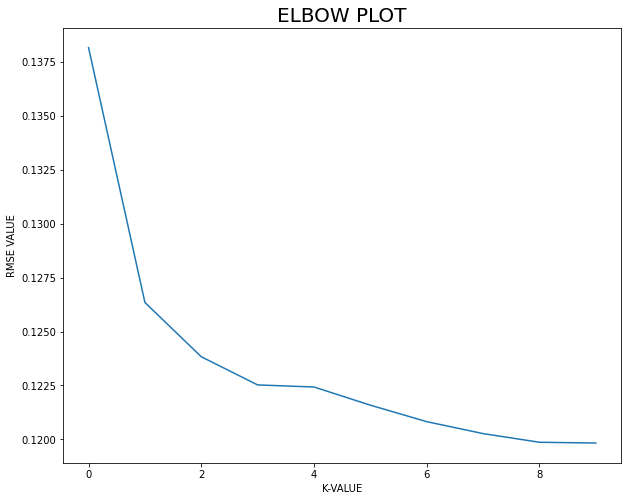

In [ ]:
#plotting the rmse values against k values

fig,ax=plt.subplots(figsize=(10,8))
ax.plot(rmse_val)
ax.set_xlabel('K-VALUE', fontsize=10)
ax.set_ylabel('RMSE VALUE' ,fontsize=10)
ax.set_title('ELBOW PLOT' ,fontsize=20)

###XGBOOST

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

In [ ]:
normalized_data = pd.read_csv('normalized.csv')

In [ ]:
normalized_data.shape

In [ ]:
#Training the dataset using XGBoost model

X = normalized_data.drop(['price'],axis=1)
y = normalized_data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # For training
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #For Validation

print("There are {} Training Data".format(X_train.shape[0]))
print("There are {} Testing Data".format(X_test.shape[0]))
print("There are {} Validation Data".format(X_valid.shape[0]))


In [ ]:
#Fitting the model using default parameters

xgbr = xgb.XGBRegressor() 
print(xgbr)
XGBRegressor()
#Fitting the model
xgbr.fit(X_train, y_train)
#check the model for training accuracy scores
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)
# Predict test data and check accuracy
ypred = xgbr.predict(X_test)
mae = mean_absolute_error(y_test, ypred)
mse = mean_squared_error(y_test, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_test, ypred)
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)


booster - tree
min_child_weight - 1
max_depth - 6
max_leaf_nodes- either this or depth
gamma - 0
max_delta_step = 0
subsample = 1
colsample_bytree = 1
colsample_bylevel = 1
lambda = 1
alpha = 0
scale_pos_weight = 1
objective - reg:linear
seed = 0

Learning rate lower

In [ ]:
    # base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #    colsample_bynode=1, colsample_bytree=1, gamma=0,
    #    importance_type='gain', learning_rate=0.1, max_delta_step=0,
    #    max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
    #    n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
    #    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    #    silent=None, subsample=1, verbosity=1)

Both methods show that the model is 70% accurate on average

In [ ]:
#Predict validation data and check the prediction accuracy using mse and rmse metrics
y_pred_valid = xgbr.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred_valid)
mse = mean_squared_error(y_valid, y_pred_valid)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_valid, y_pred_valid)
print("R2: %.2f" % r2)
print("MAE: %.2f" %mae)

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Original data and predicted data")
plt.legend()
plt.show()

In [ ]:
#do hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

param_tuning = {
'learning_rate': [0.01, 0.1],
'max_depth': [3, 5, 7, 10],
'min_child_weight': [1, 3, 5],
'subsample': [0.5, 0.7],
'colsample_bytree': [0.5, 0.7],
'objective': ['reg:squarederror']
    }
xgb_model = XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)
gsearch.fit(X_train,y_train)

gsearch.best_params_
    

   

In [ ]:
#testing you model using best parameters - validation
best_model = XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.1,
 max_depth= 7,
 min_child_weight= 3,
 objective='reg:squarederror',
 subsample= 0.7)

best_model.fit(X_train, y_train)
#check the model for training accuracy scores
score = best_model.score(X_valid, y_valid)  
print("HPT score: ", score)

In [ ]:
#testing you model using best parameters - validation
best_model = XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.1,
 max_depth= 7,
 min_child_weight= 5,
 objective='reg:squarederror',
 subsample= 0.7)

best_model.fit(X_train, y_train)
#check the model for training accuracy scores
score = best_model.score(X_valid, y_valid)  
print("HPT score: ", score)

In [ ]:
best_model = XGBRegressor(colsample_bytree= 0.7, #testing using hpt
 learning_rate= 0.1,
 max_depth= 7,
 min_child_weight= 5,
 objective='reg:squarederror',
 subsample= 0.7)

best_model.fit(X_test, y_test)
#check the model for training accuracy scores
score = best_model.score(X_test, y_test)  
print("HPT score: ", score)

In [ ]:
#validation hpt
ypred = best_model.predict(X_valid) #checking the metrics
mse = mean_squared_error(y_valid, ypred)
mae = mean_absolute_error(y_valid, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_valid, ypred)
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)

In [ ]:
ypred = best_model.predict(X_test) #checking the metrics
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_test, ypred)
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
#Randomized search cv

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1,cv=5)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
#final one
best_model_rs = XGBRegressor(subsample= 0.6, n_estimators= 1000,max_depth= 5, learning_rate= 0.01,colsample_bytree= 0.7999999999999999, colsample_bylevel= 0.4)

best_model_rs.fit(X_train, y_train)
#check the model for training accuracy scores
score = best_model_rs.score(X_valid, y_valid)  
print("HPT score random search: ", score)

In [ ]:
#CHECKING FOR RANDOMIZED SEARCH

best_model_rs = XGBRegressor(subsample= 0.5, n_estimators= 100,max_depth= 6, learning_rate= 0.2,colsample_bytree= 0.7, colsample_bylevel= 0.6)

best_model_rs.fit(X_train, y_train)
#check the model for training accuracy scores
score = best_model_rs.score(X_valid, y_valid)  
print("HPT score random search: ", score)

In [ ]:
#validation randomsearch final
ypred = best_model_rs.predict(X_valid)
mse = mean_squared_error(y_valid, ypred)
mae = mean_absolute_error(y_valid, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_valid, ypred)
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)


In [ ]:
#testing randomsearch final
ypred = best_model_rs.predict(X_test)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("MAE: %.2f" % mae)
print("RMSE: %.2f" % (mse**(1/2.0)))
r2 = r2_score(y_test, ypred)
print("R2: %.2f" % r2)

In [ ]:
#plot some graphs to check results

In [ ]:
#choosing cross validation to evaluate training score
scores = cross_val_score(xgbr, X, y,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())
scores

In [ ]:
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
#Using Kfold cross validation method to get accuracy
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X, y, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())